# Skin Cancer Detencion


Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

![skin cancer](http://www.justscience.in/wp-content/uploads/2017/12/what-causes-skin-cancer.jpg)





In [ ]:
from fastai.vision.all import *
from fastai.callback.hook import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

import os
print(os.listdir("../input"))

NameError: name 'torch' is not defined

## Exploratory Data Analysis

In [2]:
# Paths and roots to the important files
path='../input/'
csv_file='../input/HAM10000_metadata.csv'

In [3]:
df=pd.read_csv(csv_file).set_index('image_id')
df.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


In [4]:
# Categories of the diferent diseases
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
df.dx=df.dx.astype('category',copy=True)
df['labels']=df.dx.cat.codes # Convert the labels to numbers
df['lesion']= df.dx.map(lesion_type_dict)
df.head()

,lesion_id,dx,dx_type,age,sex,localization,labels,lesion
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis


In [6]:
print(df.lesion.value_counts())


lesion
Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: count, dtype: int64


In [7]:
df.loc['ISIC_0027419','lesion']

'Benign keratosis '

## Countplot
Here we notice tha we have data imbalance 

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='count', ylabel='lesion'>

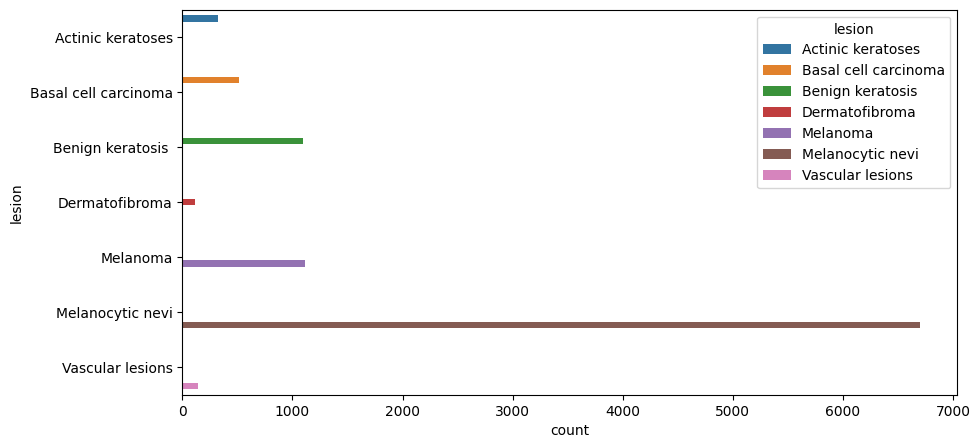

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

## Dataset

In [ ]:
def get_label(img_path):
    """Get label from image path"""
    img_name = img_path.name[:-4]  # Remove .jpg extension
    return df.loc[img_name, 'lesion'] if img_name in df.index else 'unknown'

NameError: name 'ImageItemList' is not defined

In [ ]:
def get_data(bs, size):
    # Define path and get image files
    path = Path('../input')
    
    # Get all jpg files
    files = get_image_files(path)
    
    # Create DataBlock
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_y=get_label,
        splitter=RandomSplitter(valid_pct=0.15, seed=42),
        item_tfms=Resize(size),
        batch_tfms=aug_transforms(flip_vert=True)
    )
    
    # Create DataLoaders
    dls = dblock.dataloaders(path, bs=bs)
    return dls

In [ ]:
dls = get_data(16, 224)

In [ ]:
# Fastai v2 automatically handles classes
print(f"Classes: {dls.vocab}")
print(f"Number of classes: {len(dls.vocab)}")

In [ ]:
dls.show_batch(max_n=9)

## Model ResNet50 

In [ ]:
learner = vision_learner(dls, resnet50, metrics=accuracy)

In [ ]:
# Fastai v2 automatically uses CrossEntropyLoss for classification
print(f"Loss function: {learner.loss_func}")

In [ ]:
learner.lr_find()

In [ ]:
# Training với early stopping
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

# Giai đoạn 1: Frozen training với early stopping
learner.fit_one_cycle(30, 3e-3, cbs=[
    EarlyStoppingCallback(monitor='valid_loss', patience=5),
    SaveModelCallback(monitor='accuracy', fname='best_frozen')
])

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()

In [ ]:
# Giai đoạn 2: Fine-tuning với early stopping
lr = 1e-6
learner.fit_one_cycle(15, slice(3*lr, 10*lr), cbs=[
    EarlyStoppingCallback(monitor='valid_loss', patience=3),
    SaveModelCallback(monitor='accuracy', fname='best_finetuned')
])

In [ ]:
# Save model cuối cùng
learner.save('stage-1')

# Save model cho Kaggle (để đảm bảo)
import os
model_dir = '/kaggle/working/models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Export model để có thể download
learner.export('/kaggle/working/resnet50_skin_cancer_model.pkl')
print("Model đã được save tại:")
print("- stage-1.pth (fastai format)")
print("- resnet50_skin_cancer_model.pkl (export format)")
print("- best_frozen.pth và best_finetuned.pth (từ callbacks)")

# Hiển thị các file đã lưu
import glob
saved_files = glob.glob('/kaggle/working/**/*.p*', recursive=True)
print(f"\nCác file model đã lưu: {saved_files}")

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,8))

In [ ]:
interp.most_confused()

## Inference

In [ ]:
# For inference, we can use the same learner or create a new one
pred_dls = get_data(16, 224)

In [ ]:
# Fastai v2 automatically handles classes
print(f"Prediction classes: {pred_dls.vocab}")

In [ ]:
# This method is not needed in fastai v2
# We can directly use the learner for prediction

In [ ]:
# Load the saved model for prediction
predictor = learner  # In fastai v2, we can use the same learner

In [ ]:
img = PILImage.create('../input/ham10000_images_part_2/ISIC_0029886.jpg')
img.show()

In [ ]:
pred_class, pred_idx, outputs = predictor.predict(img)
print(f"Predicted class: {pred_class}")
print(f"Prediction probabilities: {outputs}")

## Predictions

In [ ]:
# Predictions of the validation data
preds_val, y_val = learner.get_preds()

### Roc Curve
With the ROC curve we will mesuare how good it's our model

In [ ]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(y_val.numpy(), preds_val.numpy()[:,1], pos_label=1)

#  ROC area
pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Heatmap

In [ ]:
# Get a sample from validation data
x, y = dls.valid.one_batch()
x_sample = x[2]
y_sample = y[2]

# Show the image
show_image(x_sample)
print(f"Label: {dls.vocab[y_sample]}")

In [ ]:
def heatMap(x, y, dls, learner, size=(0, 224, 224, 0)):
    """HeatMap using fastai v2"""
    
    # Evaluation mode
    m = learner.model.eval()
    
    # Prepare the image
    x_tensor = x.unsqueeze(0).to(device=default_device())
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(x_tensor)
            preds[0, int(y)].backward()

    # Activations    
    acts = hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts = acts.mean(0)
    
    # Show HeatMap
    _, ax = plt.subplots()
    show_image(x, ax=ax)
    ax.imshow(avg_acts, alpha=0.6, extent=size,
              interpolation='bilinear', cmap='magma')

In [ ]:
heatMap(x_sample, y_sample, dls, learner)